# Central-eastern Pacific sea surface temperature network

- create a climate network from spatial central-eastern Pacific SST data
- degree centrality for each node of the network
- betweenness centrality for each node of the network
- average spatial link length of each node

## Hints:
- data: rows correspond to years and columns correspond to different grid points
- location: lats.txt and lons.txt
- adjacency matrix: 540x540, use 80%-quantile
- to plot a local network property such that values can be identified with 
  the correct grid point on the map, reshaping the respective 2D-array to 
  a 3D-array with dimensions (t=50, lat=18, lon=30) can be helpful 
- using a meshgrid for the latitudes and longitudes will be helpful 
  for the spatial link length distribution

## The data set is imported.

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy.ma as ma
import math
# networks and spatial plotting
import networkx as nx
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
%matplotlib inline

# load data (with masked NAN values)
sst = ma.masked_invalid(np.loadtxt("sst_enso.txt"), copy=True)
lats = np.loadtxt('lats.txt')
lons = np.loadtxt('lons.txt')
years = np.arange(1962, 2012)
# reshape data array
La, Lo = 18, 30
T = 50
sst_latlon = sst.reshape((T, La, Lo))

## Network construction

Compute the pairwise cross-correlations using the numpy.ma package (NAN-values are masked). Pick a value for the threshold (80% quantile) and generate the adjacency matrix.

In [2]:
# cross-correlation matrix (this can take a few minutes)
a_corr = np.corrcoef(sst.T)
# self-correlations should not contribute to quantile:
np.fill_diagonal(a_corr, np.nan)

In [3]:
# adjacency matrix (80%-quantile)
alpha = .8
thresh = np.nanquantile(a_corr, alpha)
a_adj = np.where((a_corr)>thresh, 1, 0)
# no self-links
np.fill_diagonal(a_adj, 0)
# transform into network
G=nx.from_numpy_matrix(a_adj)

## Degree centrality

Define a function for plotting the results spatially on a map (using Basemap).
    
The result is very similar to the first EOF. Regions with high node degree correspond to regions that load strongly onto the first PC (which represents the ENSO cycle).

In [4]:
def plot_map(arr, title):
    fig = plt.figure(figsize=(14,8))
    m=Basemap(projection='mill',lat_ts=20,llcrnrlon=lons.min(), \
      urcrnrlon=lons.max(),llcrnrlat=lats.min(),urcrnrlat=lats.max(), \
      resolution='c')
    # convert the lat/lon values to x/y projections.
    x, y = m(*np.meshgrid(lons,lats))
    # plot the field using the fast pcolormesh routine 
    # set the colormap to jet.
    m.pcolormesh(x,y, arr,shading='auto',cmap=plt.cm.coolwarm)
    m.colorbar(location='right',label=title)
    # Add a coastline and axis values.
    m.drawcoastlines()
    #m.fillcontinents()
    m.drawmapboundary()
    m.drawparallels(np.arange(-90.,90.,30.),labels=[1,0,0,0])
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])

In [5]:
## Degree centrality
degrees = np.array([val for (node, val) in G.degree()])
# reshaping the degrees
Degree=degrees.reshape((La,Lo))
degc = np.where(Degree==0, np.nan, Degree)

# Plot
plot_map(degc, 'degree centr.')

## Betweenness centrality

The bordering region that surrounds the 'ENSO tongue' that extends from the South American westcoast along the equator works as a mediator for SST variability. On the other hand, the core regions of the coherent regions do not act as strong mediators.

<ipython-input-6-02dfb1df97bf>:8: RuntimeWarning: invalid value encountered in log
  plot_map(np.log(betweenness), 'betweenness centrality')


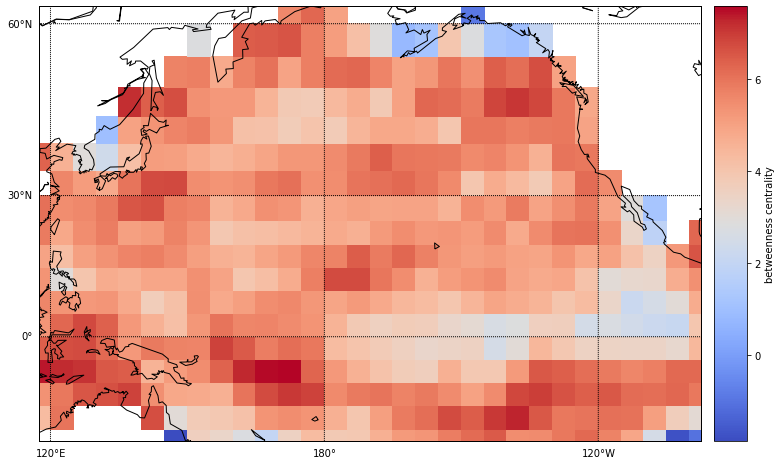

In [6]:
betw0 = nx.betweenness_centrality(G, normalized=False)
# transform the dictionary into a numpy array and reshape
betw = np.array(list(betw0.items()), dtype=float)[:,1]
betw_resh = betw.reshape((La,Lo))
betweenness = np.where(betw_resh==0, np.nan, betw_resh)
#np.where(np.log(a_closeness)<np.nanquantile(np.log(a_closeness), .99), np.log(a_closeness), np.nan)
# Plot
plot_map(np.log(betweenness), 'betweenness centrality')

## Average spatial link lengths

In [7]:
# Define the supplied function to compute the great circle distance
def great_circ_dist(lat1, lon1, lat2, lon2):
    R = 6373.0
    lat1, lon1 = math.radians(lat1), math.radians(lon1)
    lat2, lon2 = math.radians(lat2), math.radians(lon2)
    # distance computation
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    if a > 1: a=1
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

Generate lat&lon arrays to match each element in the adjacency matrix to geographical location using a meshgrid


In [8]:
a_meshlon, a_meshlat = np.meshgrid(lons,lats)
a_mlon, a_mlat = a_meshlon.ravel(), a_meshlat.ravel()

Loop over all nodes while ensuring that the spatial distance is only computed for those that are linked in the network!

In [9]:
# distance loop
L = La*Lo
a_dist = np.full_like(a_adj, 0)
for i in (range(L)):
    for j in range(L):
        # link condition:
        if a_adj[i, j]:
            dist =  great_circ_dist(a_mlat[i], a_mlon[i], a_mlat[j], a_mlon[j])
            a_dist[i,j] = dist

Compute the average link length from all link lengths of a given node. 
    
The northern region shows the most localized variability with relatively low average spatial link lengths. Conversely, both the western and the southern edges of the studied region exhibit long links. This indicates that they are affected by the characteristic ENSO SST variability from the coherent core regions.

In [10]:
# only average over non-zero entries
a_nonzero = np.where(a_dist!=0, a_dist, np.nan)
# averaging:
a_meanlinklen = np.nanmean(a_nonzero, axis=0).reshape((La,Lo))

# Plot
plot_map(a_meanlinklen, 'avg. spatial link length [km]')

<ipython-input-10-bf286e0857e1>:4: RuntimeWarning: Mean of empty slice
  a_meanlinklen = np.nanmean(a_nonzero, axis=0).reshape((La,Lo))
